## Packages

In [2]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

## Loading the data

In [3]:
raw_data = yfinance.download (tickers = "^GSPC ^FTSE ^N225 ^GDAXI", start = "1994-01-07", 
                              end = "2019-09-01", interval = "1d", group_by = 'ticker', auto_adjust = True, treads = True)

[*********************100%***********************]  4 of 4 completed


In [4]:
df_comp = raw_data.copy()

In [5]:
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

In [6]:
df_comp = df_comp.iloc[1:]
del df_comp['^N225']
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

## Creating Returns

In [7]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1).mul(100)
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1).mul(100)
df_comp['ret_dax'] = df_comp.dax.pct_change(1).mul(100)
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1).mul(100)

## Normalizing returns. 

In [8]:
df_comp['norm_ret_spx'] = df_comp.ret_spx.div(df_comp.ret_spx[1])*100
df_comp['norm_ret_ftse'] = df_comp.ret_ftse.div(df_comp.ret_ftse[1])*100
df_comp['norm_ret_dax'] = df_comp.ret_dax.div(df_comp.ret_dax[1])*100
df_comp['norm_ret_nikkei'] = df_comp.ret_nikkei.div(df_comp.ret_nikkei[1])*100

## Splitting the Data

In [9]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## Fitting a Model

In [10]:
model_ar = ARIMA(df.ftse, order = (1,0,0)) # equivalent of AR(1)
results_ar = model_ar.fit()

## Simple Forecasting

## In time Series we expect patterns to persist as we progress trough time. So we find the pattern (select the model) and predict the future. 

In [10]:
df.tail()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei
,,,,,,,,,,,,
Date,,,,,,,,,,,,
2014-07-09,1972.829956,9808.200195,6718.000000,15302.650391,0.464427,-0.304222,0.363568,-0.076789,-193.623849,39.056133,260.939581,-33.873062
2014-07-10,1964.680054,9659.129883,6672.399902,15216.469727,-0.413107,-0.678775,-1.519854,-0.563175,172.228229,87.141370,-1090.828512,-248.427258
2014-07-11,1967.569946,9666.339844,6690.200195,15164.040039,0.147092,0.266775,0.074644,-0.344559,-61.324138,-34.248669,53.573442,-151.991545
2014-07-14,1977.099976,9783.009766,6746.100098,15296.820312,0.484355,0.835549,1.206971,0.875626,-201.932230,-107.268090,866.266436,386.255523
2014-07-15,1973.280029,9719.410156,6710.500000,15395.160156,-0.193210,-0.527714,-0.650103,0.642878,80.550866,67.748084,-466.591262,283.585757


In [12]:
# create variables that will help us change the periods easily instead of typing them up every time
# make sure the start and end dates are business days, otherwise the code will result in an error
start_date = "2014-07-15"
end_date = "2015-01-01"

## **Using the predict method called from the results object**. 

In [12]:
end_date = "2019-10-23"
df_pred = results_ar.predict(start = start_date, end = end_date)

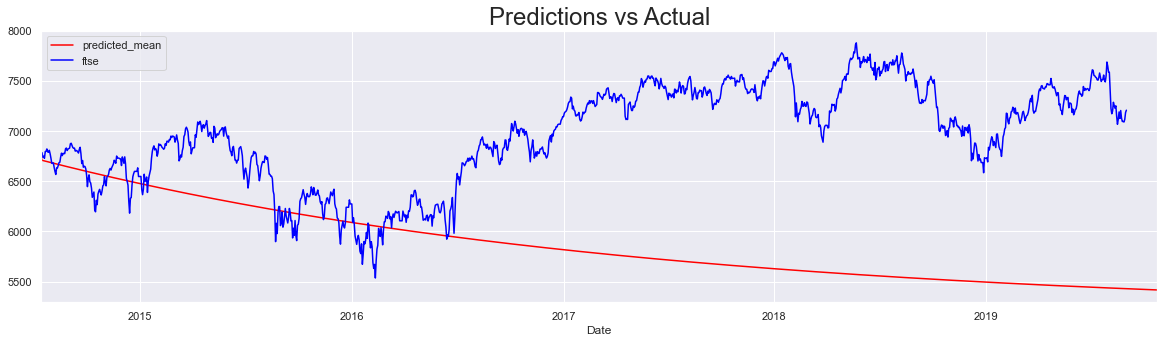

In [13]:
df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.legend()
plt.show()

### Here we use prices, they are not stationary data, and as can be seen, an AR model is not good in predicting not stationary data. 

## **Using Returns Instead**

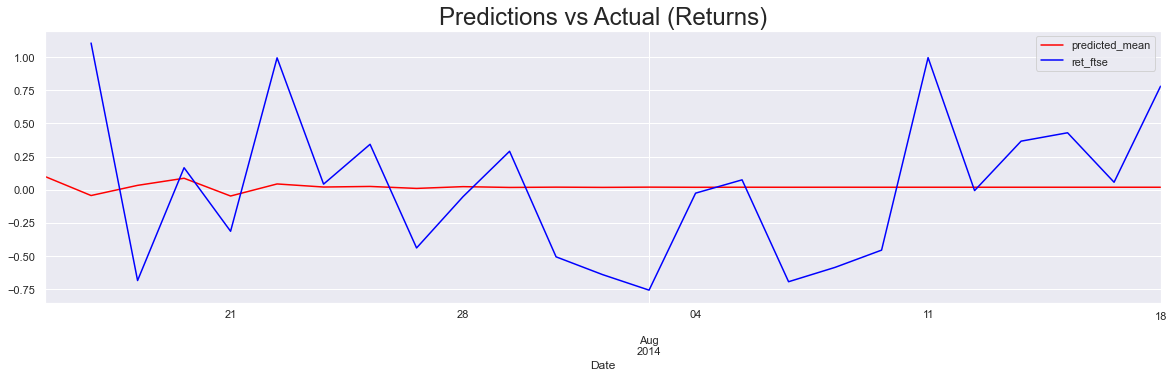

In [14]:
end_date = "2014-08-18"

model_ret_ar = ARIMA(df.ret_ftse[1:], order = (5,0,0))
results_ret_ar = model_ret_ar.fit()

df_pred_ar = results_ret_ar.predict(start = start_date, end = end_date) 

df_pred_ar[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.legend()
plt.show()

In [15]:
results_ret_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5351
Model:                 ARIMA(5, 0, 0)   Log Likelihood               -8307.926
Date:                Fri, 05 Nov 2021   AIC                          16629.851
Time:                        10:38:31   BIC                          16675.947
Sample:                    01-11-1994   HQIC                         16645.952
                         - 07-15-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0192      0.014      1.357      0.175      -0.009       0.047
ar.L1         -0.0222      0.009     -2.557      0.011      -0.039      -0.005
ar.L2         -0.0531      0.008     -6.947      0.000      -0.068      -0.038
ar.L3         -0.0807      0.008    -10.543      0.000      -0.096      -0.066
ar.L4          0.0422      0.008      5.322      0.000       0.027       0.058
ar.L5         -0.0561      0.008     -7.341      0.000      -0.071      -0.041
sigma2         1.3064      0.013     96.788      0.000       1.280       1.333
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              7339.56
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### MA

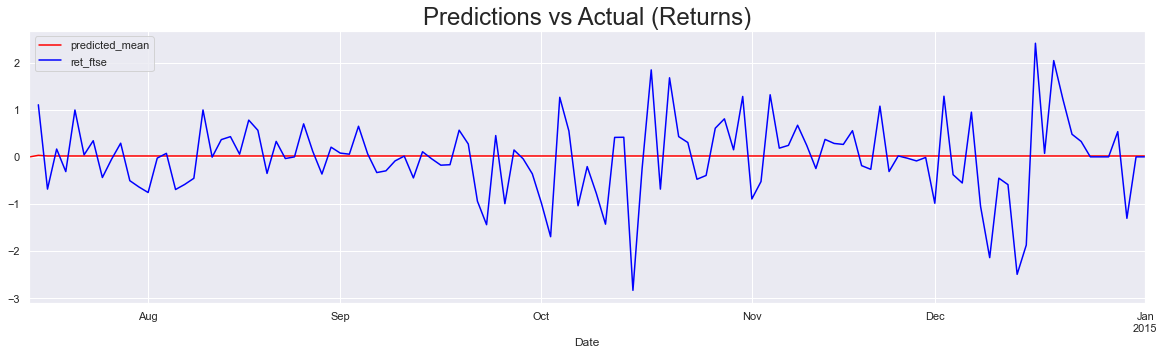

In [16]:
end_date = "2015-01-01"

model_ret_ma = ARIMA(df.ret_ftse[1:], order=(0,0,1))
results_ret_ma = model_ret_ma.fit()

df_pred_ma = results_ret_ma.predict(start = start_date, end = end_date) 

df_pred_ma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.legend()
plt.show()

## The predictions are very close to 0. 

In [17]:
df_pred_ma.head()

2014-07-15   -0.002095
2014-07-16    0.032673
2014-07-17    0.019116
2014-07-18    0.019116
2014-07-21    0.019116
Freq: B, Name: predicted_mean, dtype: float64

### ARMA

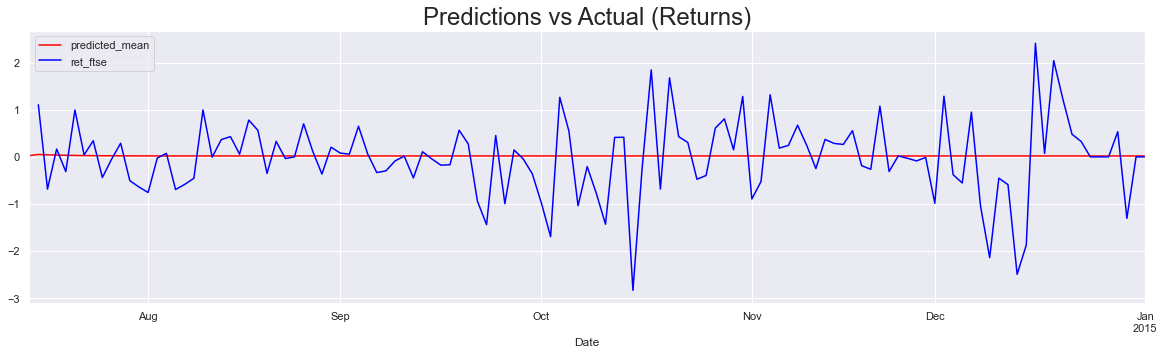

In [18]:
model_ret_arma = ARIMA(df.ret_ftse[1:], order=(1,0,1))
results_ret_arma = model_ret_arma.fit()

df_pred_arma = results_ret_arma.predict(start = start_date, end = end_date)

df_pred_arma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.legend()
plt.show()

In [19]:
df_pred_arma.head()

2014-07-15    0.026662
2014-07-16    0.051209
2014-07-17    0.043855
2014-07-18    0.038188
2014-07-21    0.033822
Freq: B, Name: predicted_mean, dtype: float64

In [20]:
df_pred_arma.tail()

2014-12-26    0.019162
2014-12-29    0.019162
2014-12-30    0.019162
2014-12-31    0.019162
2015-01-01    0.019162
Freq: B, Name: predicted_mean, dtype: float64

### ARMAX: exogenous variables. 

### Including outside factors improved the predictive power drastically. 

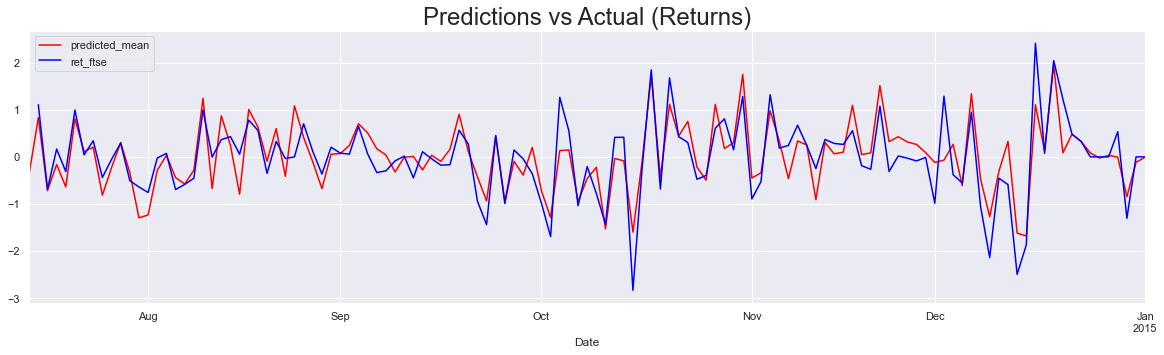

In [21]:
model_ret_armax = ARIMA(df.ret_ftse[1:], exog = df[["ret_spx","ret_dax","ret_nikkei"]][1:], order = (1,0,1))
results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test[["ret_spx","ret_dax","ret_nikkei"]][start_date:end_date]) 

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.legend()
plt.show()

## Predictions : in-sample estimations. (testing or validation set used). MAX models can be great when we are analysing data but poor when we are trying to forecast it. 

## Forecast : out-of-sample estimations. We don't have information about the future so we can't use the test or validation set to compare our results. 

## If we are going to use ARIMA or ARIMAX we must use prices instead of returns because prices are non-stationary data and they must be used as the endogenous ( the variable we are modeling) and the exogneous data. 

### SARMA

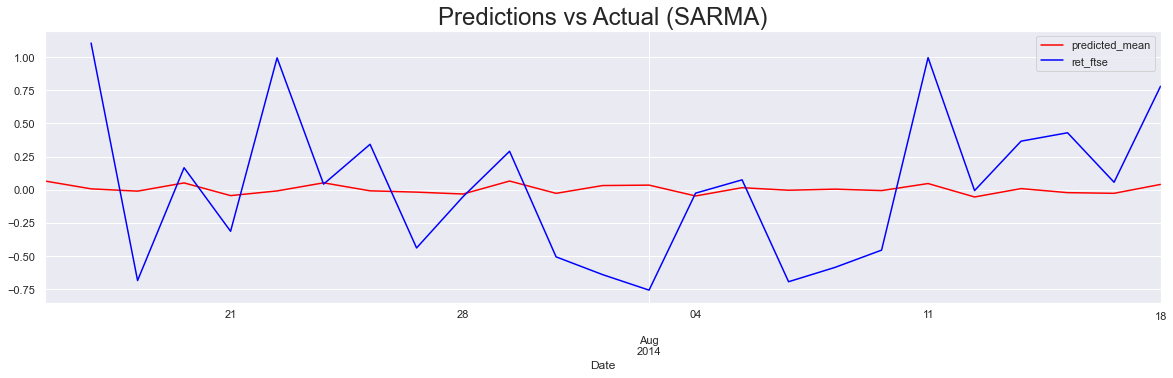

In [22]:
end_date = "2014-08-18"
model_ret_sarma = SARIMAX(df.ret_ftse[1:], order = (3,0,4), seasonal_order = (3,0,2,5)) # lenght of the cyclical pattern is 5 because there are 5 bussiness days. 
results_ret_sarma = model_ret_sarma.fit()

df_pred_sarma = results_ret_sarma.predict(start = start_date, end = end_date)

df_pred_sarma[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (SARMA)", size = 24)
plt.legend()
plt.show()

### SARIMAX

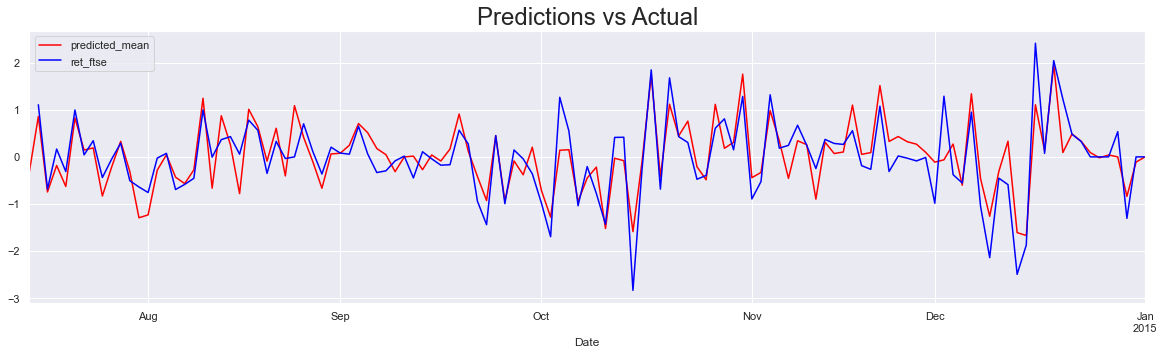

In [23]:
end_date = "2015-01-01"
model_ret_sarimax = SARIMAX(df.ret_ftse[1:], exog = df[["ret_spx","ret_dax","ret_nikkei"]][1:], 
                            order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarimax = model_ret_sarimax.fit()

df_pred_sarimax = results_ret_sarimax.predict(start = start_date, end = end_date, 
                                              exog = df_test[["ret_spx","ret_dax","ret_nikkei"]][start_date:end_date]) 

df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.legend()
plt.show()

### Auto ARIMA

#### It returns a fit model so we don't need to apply the fit method. 

In [24]:
model_auto = auto_arima(df.ret_ftse[1:], exogenous = df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:],
                       m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)

In [ ]:
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods = len(df_test[start_date:end_date]),
                            exogenous = df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date]),
                            index = df_test[start_date:end_date].index)

In [ ]:
df_auto_pred.plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.legend()
plt.show()

## PITFALLS / PECULIARITIES

### Most of this models are not integrated, so they assume the data is stationary. 

### The AR model only rely on past values and the constant coefficient. The monotonous nature of the predictions makes it unreasonable. 

### The MA model, can't make long run predictions if we only rely on error terms. We can't autogenerate future residuals since we don't have actual values anymore. 

### Comparing All the Models (Returns)

In [ ]:
end_date = "2015-01-01"
df_pred_ar[start_date:end_date].plot(figsize = (20,10), color = "yellow")
df_pred_ma[start_date:end_date].plot(color = "pink")
df_pred_arma[start_date:end_date].plot(color = "cyan")
df_pred_armax[start_date:end_date].plot(color = "green")
df_pred_sarma[start_date:end_date].plot(color = "magenta")
df_pred_sarimax[start_date:end_date].plot(color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.legend(['AR','MA','ARMA','ARMAX','SARMA','SARIMAX'])
plt.title("All the Models", size = 24)
plt.show()

### Forecasting Volatility

In [13]:
mod_garch = arch_model(df_comp.ret_ftse[1:], vol = "GARCH", p = 1, q = 1, mean = "constant", dist = "Normal")
res_garch = mod_garch.fit(last_obs = start_date, update_freq = 10)

Iteration:     10,   Func. Count:     65,   Neg. LLF: 7310.187356086502
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7310.187341157545
            Iterations: 12
            Function evaluations: 74
            Gradient evaluations: 12


## Horizon states how many observations we want out model to predict for each date. So for each date we will get the predicted value for the next date. 

## Align determines wheter we math the value with the date the predictions is made on, or the one it's supposed to represent. 

In [14]:
pred_garch = res_garch.forecast(horizon = 1, align = 'target')

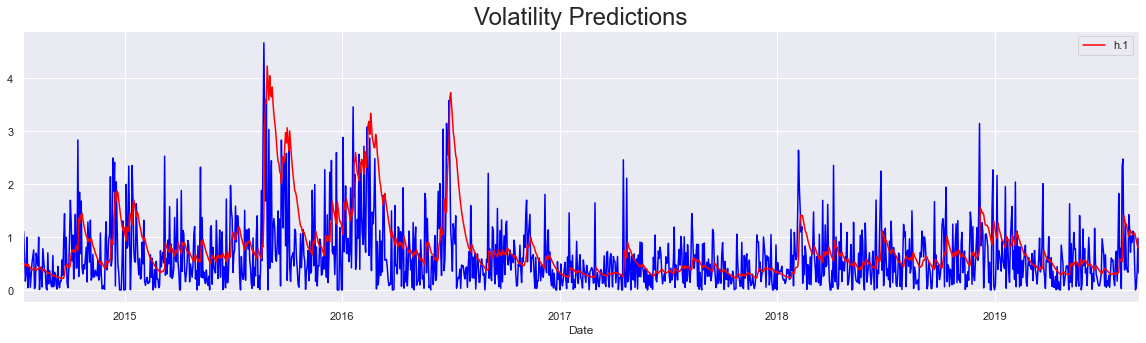

In [15]:
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color = "red", zorder = 2)
df_test.ret_ftse.abs().plot(color = "blue", zorder = 1)# volatility is always positive so we use abs() method. 
plt.title("Volatility Predictions", size = 24)
plt.show()

## Our volatility predictions are not linear. 

In [16]:
pred_garch = res_garch.forecast(horizon = 100, align = 'target')
pred_garch.residual_variance[-1:]

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-30,0.811472,0.805697,0.86732,0.940727,1.020889,1.08517,1.074223,1.067983,1.081403,1.090846,...,0.837754,0.839355,0.830751,0.81593,0.827564,0.839795,0.851102,0.864614,0.872177,0.886642


## One of the main issues about MAX models is that sometimes we miss exogenous variables so we decide to forecast the volatility of the market.  

## So sometimes we can also measure the volatility of the exogeneous variables. 

### Multvariate Regression Model

In [17]:
from statsmodels.tsa.api import VAR

In [18]:
df_ret = df[['ret_spx', 'ret_dax', 'ret_ftse', 'ret_nikkei']][1:]

## This models performs a regression in each of the time series , eg each one of the markets. 

## This models are now called vector models, because every component contains a value for each of the time series. 

## $Y_{t-1}$[S&P,FTSE,DAX,NIKKEI] : VAR : Vector autoregressive model, only includes past values $y_{t-n}$

In [19]:
model_var_ret = VAR(df_ret)
model_var_ret.select_order(20)# maximum order of the model. 
results_var_ret = model_var_ret.fit(ic = 'aic')

In [20]:
results_var_ret.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Nov, 2021
Time:                     11:08:33
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   0.330716
Nobs:                     5346.00    HQIC:                  0.263399
Log likelihood:          -30866.1    FPE:                    1.25516
AIC:                     0.227263    Det(Omega_mle):         1.23563
--------------------------------------------------------------------
Results for equation ret_spx
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.039150         0.016160            2.423           0.015
L1.ret_spx           -0.110568         0.017558           -6.297           0.000
L1.ret_dax            0.065289         0.019034           

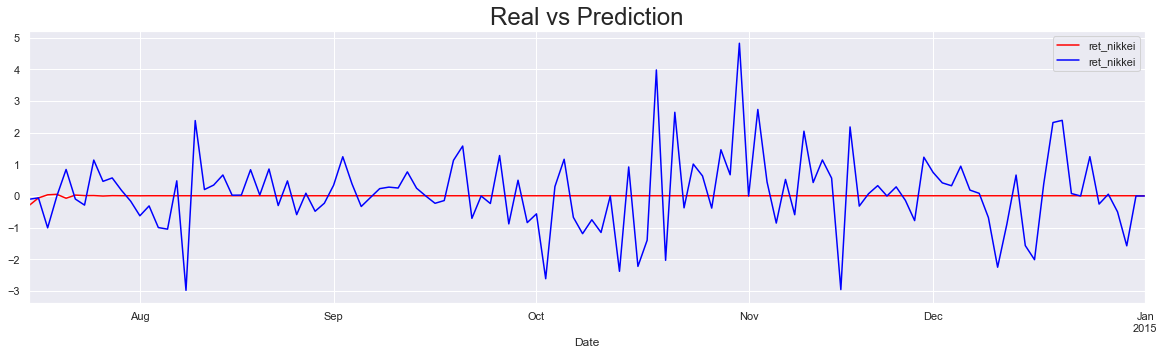

In [23]:
lag_order_ret = results_var_ret.k_ar
var_pred_ret = results_var_ret.forecast(df_ret.values[-lag_order_ret:], len(df_test[start_date:end_date]))

df_ret_pred = pd.DataFrame(data = var_pred_ret, index = df_test[start_date:end_date].index,
                                columns = df_test[start_date:end_date].columns[4:8])

df_ret_pred.ret_nikkei[start_date:end_date].plot(figsize = (20,5), color = "red")

df_test.ret_nikkei[start_date:end_date].plot(color = "blue")
plt.title("Real vs Prediction", size = 24)
plt.legend()
plt.show()

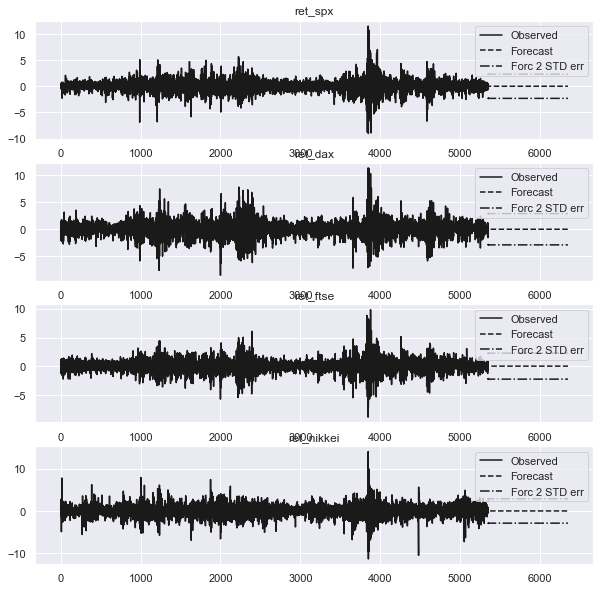

In [22]:
results_var_ret.plot_forecast(1000)
plt.show()